In [21]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np

data_folder = "data/FMNIST"

fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [22]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float() / 255
    x = x.view(-1, 28*28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)

In [23]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  return trn_dl

In [24]:
from torch.optim import SGD

def get_model():
  model = nn.Sequential(
      nn.Linear(28*28, 1000),
      nn.ReLU(),
      nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer

In [25]:
def train_batch(x, y, model, optimizer, loss_fn):
  model.train()
  # call your model like any python function on your batch of inputs
  prediction = model(x)
  # calculate the loss
  batch_loss = loss_fn(prediction, y)
  # compute gradients based of the forward pass
  batch_loss.backward()
  # apply new weights
  optimizer.step()
  # flush memory for next batch calculations
  optimizer.zero_grad()
  return batch_loss.item()

In [26]:
def accuracy(x, y, model):
  model.eval()
  # there is no need for computing and updating gradients
  with torch.no_grad():
    # make a prediction
    prediction = model(x)
  # compare if the location of maximum in each row coincides with ground truth
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()

In [27]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuracies = [], []

for epoch in range(5):
  print(epoch)
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
  epoch_losses.append(batch_loss)
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y ,model)
    epoch_accuracies.extend(is_correct)
  epoch_accuracy = np.mean(epoch_accuracies)
  losses.append(epoch_losses)
  accuracies.append(epoch_accuracy)

0
1
2
3
4


/tmp/ipython-input-3167522726.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}".format(x*100) for x in plt.gca().get_yticks()])


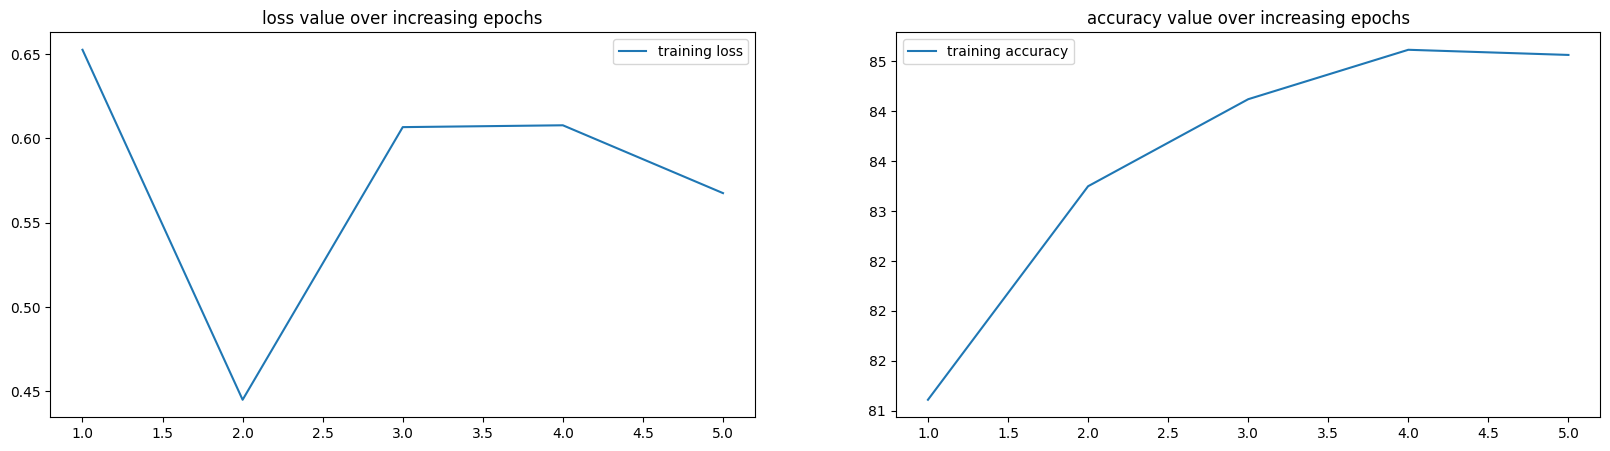

In [28]:
epochs = np.arange(5) + 1
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title("loss value over increasing epochs")
plt.plot(epochs, losses, label="training loss")
plt.legend()
plt.subplot(122)
plt.title("accuracy value over increasing epochs")
plt.plot(epochs, accuracies, label="training accuracy")
plt.gca().set_yticklabels(["{:.0f}".format(x*100) for x in plt.gca().get_yticks()])
plt.legend();